In [1]:
import zipfile
import os
def extract_datasets(data_set_zip):
    zip_file_path = os.path.join(BASE_DIR, 'datasets-compressed', data_set_zip)
    print(zip_file_path)
    extract_dir = os.path.join(BASE_DIR, 'datasets')
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    _extraction_cleanup(extract_dir)

def _extraction_cleanup(extract_dir):
    mac_side_effects = os.path.join(extract_dir, "__MACOSX")
    if os.path.exists(mac_side_effects):
        try: 
            os.remove(mac_side_effects)
        except PermissionError: 
            print("INFO: Was not able to clean macOS's side effects (__MACOSX) due to priviliage issue.\n"
                    " You can remove it manually")
            
BASE_DIR = os.getcwd()
dataset_name = 'road-dataset.zip'
extract_datasets(dataset_name)

/Users/gilpasi/Desktop/study/year-3/final-project/project/mappify/cv_labratory/segmentation_lab/datasets-compressed/road-dataset.zip


FileNotFoundError: [Errno 2] No such file or directory: '/Users/gilpasi/Desktop/study/year-3/final-project/project/mappify/cv_labratory/segmentation_lab/datasets-compressed/road-dataset.zip'

In [16]:
import numpy as np 
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import keras
import cv2
import matplotlib.pyplot as plt
from focal_loss import BinaryFocalLoss

In [75]:
BACKBONE = 'resnet34'
RESIZE = (256, 256)
preprocess_input = sm.get_preprocessing(BACKBONE)

In [76]:
from pathlib import Path

def get_images_absolute_paths(base_dir):
    return sorted([str(file.absolute())
                   for file in Path(base_dir).iterdir()
                   if file.is_file()])


In [77]:
def load_images(image_paths):
    images = []
    for path in image_paths:
        if ".DS_Store" not in path: 
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, RESIZE)
            images.append(img)
    return np.array(images)


In [78]:
def load_masks(mask_paths):
    masks = []
    for path in mask_paths:
        mask = cv2.imread(path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, RESIZE )
        mask = np.expand_dims(mask, axis=-1)
        mask = np.where(mask>0, 1, 0)
        masks.append(mask)
    return np.array(masks)

In [79]:
def plot_image_mask_result(x, y, z=None):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(x)
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow( np.zeros(x.shape) if z is None else z, cmap='gray')
    plt.show()

In [80]:
try:
    CLASS = 'road'
    BASE_DIR = os.path.join(os.getcwd(), 'datasets', CLASS)
    x_train_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'train'))
    y_train_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'trainannot'))
    x_val_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'val'))
    y_val_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'valannot'))
    x_test_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'test'))
    y_test_path = get_images_absolute_paths(os.path.join(BASE_DIR, 'testannot'))
except FileNotFoundError:
    raise FileNotFoundError (f"class {CLASS} did not have a directory, go to first code snippet and\n"
          f"run it again with {CLASS}-dataset.zip or reproduce the data-set with the\n"
          "original_training_notebook.ipynb notebook")

In [81]:
y_train = load_masks(y_train_path)
x_train = load_images(x_train_path)
y_val = load_masks(y_val_path)
x_val = load_images(x_val_path)
y_test = load_masks(y_test_path)
x_test = load_images(x_test_path)

In [73]:
def custom_compile():
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    model.compile('Adam', loss=BinaryFocalLoss(gamma=2), metrics=metrics)

In [82]:
model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid',
    input_shape=(RESIZE[0], RESIZE[1], 3))
custom_compile()

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [14]:
import keras.callbacks
history = "Model was never ran"
history = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/50


ValueError: in user code:

    File "/opt/anaconda3/envs/segenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/segenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/segenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/segenv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/envs/segenv/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/segenv/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 360, 480, 3)


In [10]:
from tensorflow.keras.models import load_model
import segmentation_models as sm

LAB_PATH = os.getcwd()
MODEL_NAME = "road_segmentor"
MODEL_PATH = os.path.join(LAB_PATH, "products", MODEL_NAME,"model.keras" )

answer = input("This might override your model! Are you sure? y/n")
if(answer == 'y'):
    model = load_model(MODEL_PATH,compile=False)
    custom_compile()
    


In [11]:
evaluation = model.evaluate(x_test, y_test)
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

NameError: name 'x_test' is not defined

In [12]:
THRESHOLD = 0.5
prediction = model.predict(x_test)
prediction = np.where(prediction > THRESHOLD, 1, 0)

NameError: name 'x_test' is not defined

['/Users/gilpasi/Desktop/study/year-3/final-project/project/mappify/cv_labratory/segmentation_lab/datasets/google-maps-sample/.DS_Store', '/Users/gilpasi/Desktop/study/year-3/final-project/project/mappify/cv_labratory/segmentation_lab/datasets/google-maps-sample/1.png', '/Users/gilpasi/Desktop/study/year-3/final-project/project/mappify/cv_labratory/segmentation_lab/datasets/google-maps-sample/2.png', '/Users/gilpasi/Desktop/study/year-3/final-project/project/mappify/cv_labratory/segmentation_lab/datasets/google-maps-sample/3.png', '/Users/gilpasi/Desktop/study/year-3/final-project/project/mappify/cv_labratory/segmentation_lab/datasets/google-maps-sample/4.png']
1/1 [==============================] - 0s 298ms/step


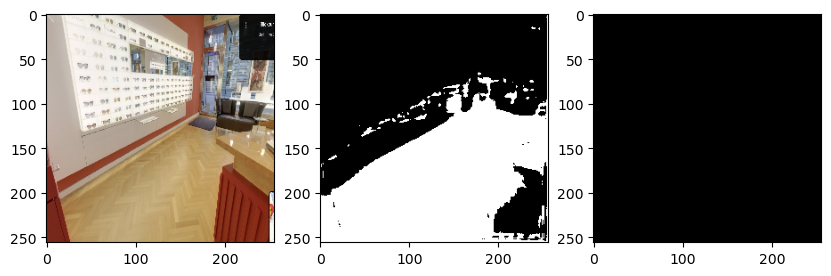

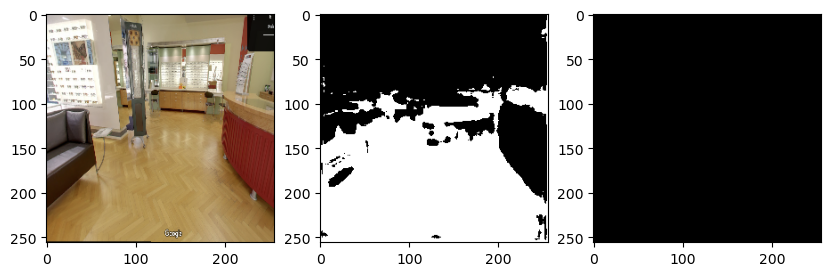

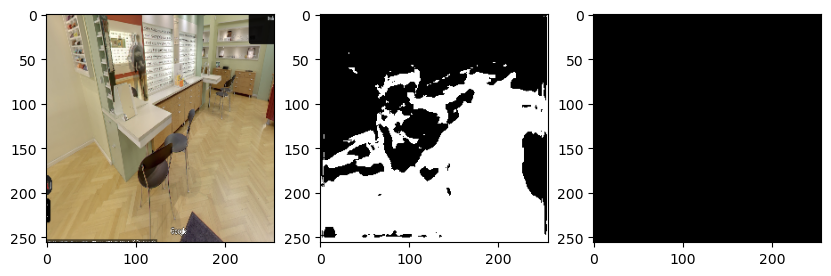

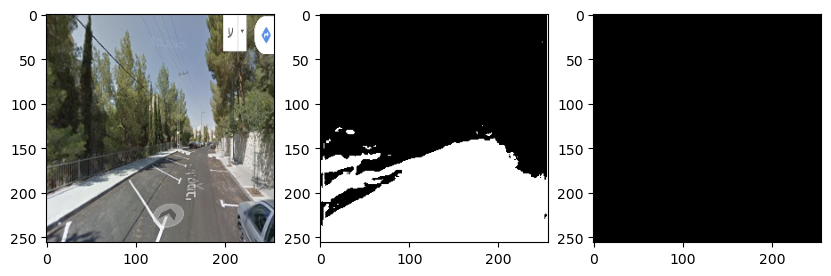

In [33]:
def check_real_data():
    sample_dir_path = os.path.join('datasets', 'google-maps-sample')
    samples_path = get_images_absolute_paths(sample_dir_path)
    print(samples_path)
    sample_data = load_images(samples_path)
    THRESHOLD = 0.07
    prediction = model.predict(sample_data)
    prediction = np.where(prediction > THRESHOLD, 1, 0)
    for i in range(len(sample_data)):
        plot_image_mask_result(sample_data[i],prediction[i])
extract_datasets("google-maps-sample.zip")
check_real_data()

In [16]:
index = np.random.randint(0, x_test.shape[0])
plot_image_mask_result(x_test[index], y_test[index], prediction[index])

NameError: name 'x_test' is not defined

In [67]:
def save_model(model,model_params, name=None):
    import json
    from datetime import datetime
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    if name is None:
        name = "segmentor " + current_time

    segmentor_path = os.path.join(os.getcwd(), name)
    model_path = os.path.join(segmentor_path, "model.keras")
    report_path = os.path.join(segmentor_path, "report.json")

    os.makedirs(segmentor_path)

    with open(report_path, 'w') as file:
        json.dump(model_params, file, indent=4)
    model.save(model_path)
    print(f"INFO: Segmetor saved successfully to- \n{segmentor_path}")

print(model.optimizer)
params={
    'Dataset': dataset_name,
    'Model': 'Unet',
    'Backbone': BACKBONE,
    'Image_resize': f"{RESIZE[0]}X{RESIZE[1]}",
    'Optimizer' : model.optimizer.__class__.__name__, 
    'Loss Function': model.loss.__class__.__name__,
    'None Loss Metrics': model.metrics_names[1:], 
    'Loss': evaluation[0],
    'Accuracy': evaluation[1],
}
save_model(model,params)

INFO: Segmetor saved successfully to- 
/Users/gilpasi/Desktop/study/year-3/final project/project/mappify/cv_labratory/segmentation_lab/segmentor 2024-05-08 00:21:18.861918
